In [ ]:
import os
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


img_size = 480  # image: 640 x 480
in_channels = 1

if in_channels == 1:    
    # Data transforms
    normalize = transforms.Normalize(mean=[0.5],
                                     std=[0.5])
else:
    # Data transforms
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.Resize((int(img_size*1.1), int(img_size*1.1))),  # Resize before cropping
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0), ratio=(0.9, 1.1)),  # crop focused near center
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Grayscale(num_output_channels=in_channels),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    normalize
])

test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.Grayscale(num_output_channels=in_channels),
    transforms.ToTensor(),
    normalize
])

import os
from sklearn.model_selection import StratifiedShuffleSplit
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import torch

# 데이터 경로 설정
root_dir = './Refined_mix'
base_dataset = ImageFolder(root=root_dir)

# 레이블 추출
targets = base_dataset.targets

# Stratified Split
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(range(len(targets)), targets))

train_dataset = ImageFolder(root=root_dir, transform=train_transform)
test_dataset = ImageFolder(root=root_dir, transform=test_transform)

# Subset으로 분할
train_dataset = Subset(train_dataset, train_idx)
test_dataset = Subset(test_dataset, test_idx)

# DataLoader 정의
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
import numpy as np

In [4]:
sum(np.array(targets)==1)

273

In [5]:
sum(np.array(targets)==0)

184

In [6]:
import torch
import torchvision
import matplotlib.pyplot as plt

def show_image_batch(images, title, nrow=8, padding=2, normalize=True, value_range=None, cmap=None):
    """
    images: torch.Tensor of shape [B, C, H, W] or [B, H, W] (grayscale)
    nrow: number of images per row in the grid
    padding: padding between images
    normalize: whether to normalize images to [0, 1]
    value_range: (min, max) tuple for normalization
    cmap: for grayscale images, e.g., 'gray'
    """
    if images.dim() == 3:
        # [B, H, W] → [B, 1, H, W]
        images = images.unsqueeze(1)

    grid = torchvision.utils.make_grid(
        images, nrow=nrow, padding=padding, normalize=normalize)

    # Convert CHW to HWC for matplotlib
    npimg = grid.permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(12, 6))
    if npimg.shape[2] == 1:  # grayscale
        plt.imshow(npimg.squeeze(), cmap=cmap or 'gray')
    else:
        plt.imshow(npimg)
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [7]:
for x, y in train_loader:
    break

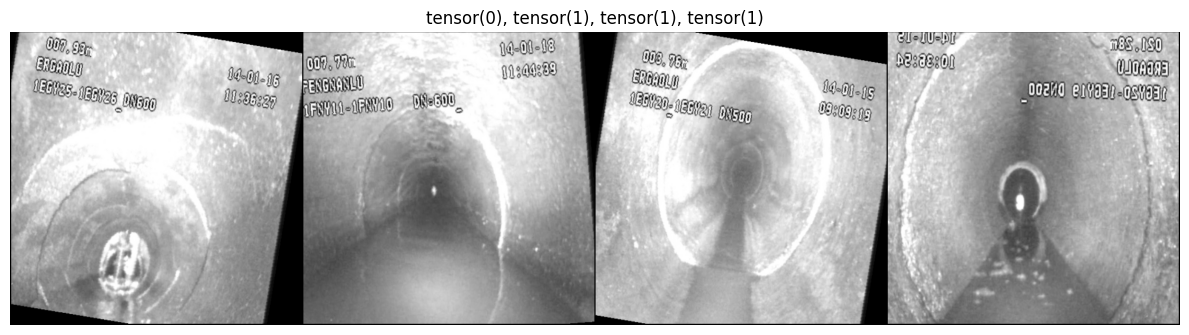

In [8]:
show_image_batch(x[:4], title=", ".join([str(item) for item in y[:4]]))

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [10]:
patch_len = 32
emb_dim = 24
n_heads = 4
d_layers = 2

patch_size = 120
num_labels = 2

In [11]:
patch_num = (img_size // patch_size) ** 2
seq_len = patch_num*patch_len
patch_num, seq_len

(16, 512)

In [12]:
from types import SimpleNamespace
# Model parameters
model_params = {
    'features': 'S',
    'seq_len': seq_len,
    'pred_len': patch_len*num_labels,
    'd_layers': d_layers,
    'dec_in': 1, ## channel
    'des': 'Exp',
    'itr': 1,
    'd_model': emb_dim,
    'd_ff': emb_dim*2,
    'n_heads': n_heads,
    'QAM_end': 0.0,
    'patch_len': patch_len,
    'stride': patch_len, ## patch_len//2
    'dropout': 0.1,
    'query_independence':False,
    'padding_patch':'end',
    'store_attn':False,
    'QAM_start':0.0,
    'classification':True
}

args = SimpleNamespace(**model_params)

In [13]:
from CATS import Model, GEGLU
classifier = Model(args=args)

In [14]:
class ResNetFront(nn.Module):
    def __init__(self, backbone='resnet50', pretrained=True, in_channels=3, out_channels=None):
        super().__init__()
        resnet = getattr(models, backbone)(pretrained=pretrained)

        # conv1 수정 (in_channels가 1인 경우)
        if in_channels == 1:
            conv1_weight = resnet.conv1.weight
            new_conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
            with torch.no_grad():
                new_conv1.weight.copy_(conv1_weight.mean(dim=1, keepdim=True))
            resnet.conv1 = new_conv1
        elif in_channels != 3:
            raise ValueError("Only in_channels=1 or 3 supported for now.")

        # 앞단 구성
        self.front = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
        )

        # 원래 layer1까지의 출력 채널 수
        self.base_out_channels = self._get_layer1_out_channels(backbone)

        # 채널 변경이 필요한 경우 1x1 conv 추가
        if out_channels is not None and out_channels != self.base_out_channels:
            self.channel_proj = nn.Conv2d(self.base_out_channels, out_channels, kernel_size=1)
        else:
            self.channel_proj = nn.Identity()

    def _get_layer1_out_channels(self, backbone):
        """ResNet 구조에 따라 layer1의 출력 채널 수 리턴"""
        if '18' in backbone or '34' in backbone:
            return 64
        elif '50' in backbone or '101' in backbone or '152' in backbone:
            return 256
        else:
            raise ValueError(f"Unknown backbone: {backbone}")

    def forward(self, x):
        x = self.front(x)
        x = self.channel_proj(x)
        return x

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchConvEncoder(nn.Module):
    def __init__(self, 
                 in_channels=3,
                 img_size=224,
                 patch_size=16, 
                 hidden_dim=128, 
                 output_dim=2048):
        super(PatchConvEncoder, self).__init__()
        
        self.patch_size = patch_size
        self.hidden_dim = hidden_dim

        # 224x224 이미지를 patch_size x patch_size 로 나눌 경우
        self.num_patches = (img_size // patch_size) ** 2
        
        # Shared conv module for all patches
        self.shared_conv = nn.Sequential(
            # nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.MaxPool2d(2),  # 각 patch를 1x1로 압축
            # nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            # nn.ReLU(),
            ResNetFront(backbone='resnet50', pretrained=True, in_channels=in_channels, out_channels=hidden_dim),
            nn.AdaptiveAvgPool2d((1, 1))  # 각 patch를 1x1로 압축
        )

        if output_dim is None:
            self.proj = None
        else:
            # 최종 projection layer (concat 후 → output_dim으로)
            self.proj = nn.Linear(self.num_patches * hidden_dim, output_dim)

    def forward(self, x):
        B, C, H, W = x.shape  # B x 3 x 224 x 224

        # 패치를 나눔
        patches = x.unfold(2, self.patch_size, self.patch_size)\
                   .unfold(3, self.patch_size, self.patch_size)  # B x C x N_patch_h x N_patch_w x patch_size x patch_size

        N_h, N_w = patches.shape[2], patches.shape[3]
        patches = patches.permute(0, 2, 3, 1, 4, 5)  # B x N_patch_h x N_patch_w x C x patch_size x patch_size
        patches = patches.reshape(-1, C, self.patch_size, self.patch_size)  # (B * N_patches) x C x patch_size x patch_size

        # shared conv 적용
        conv_outs = self.shared_conv(patches)  # (B * N_patches) x hidden_dim x 1 x 1
        conv_outs = conv_outs.view(conv_outs.size(0), -1)  # (B * N_patches) x hidden_dim

        # 원래 배치 단위로 reshape
        conv_outs = conv_outs.view(B, self.num_patches * self.hidden_dim)  # B x (num_patches * hidden_dim)

        # projection
        if self.proj is None:
            out = conv_outs
        else:
            out = self.proj(conv_outs)  # B x output_dim

        return out

In [16]:
encoder = PatchConvEncoder(in_channels=in_channels, img_size=img_size, patch_size=patch_size, 
                           hidden_dim=patch_len, output_dim=None)
x = torch.randn(8, in_channels, img_size, img_size)  # batch size = 8
y = encoder(x)
print(y.shape)  # torch.Size([8, 2048])

/home/hannibal/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hannibal/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/hannibal/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 61.5MB/s]


torch.Size([8, 512])


In [17]:
class XModel(torch.nn.Module):
    def __init__(self, encoder, classifier):
        super().__init__()
        self.encoder = encoder
        self.classifier = classifier
        
    def forward(self, x):
        x = self.encoder(x).unsqueeze(-1)
        out = self.classifier(x).squeeze()
        return out

In [18]:
model = XModel(encoder, classifier).to(device)

In [19]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_trainable_parameters(model)

237952

In [20]:
x = torch.randn(8, in_channels, img_size, img_size)  # batch size = 8
y = model(x.to(device))
print(y.shape)  # torch.Size([8, 2048])

torch.Size([8, 64])


In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [23]:
model = model.to(device)

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("#Params: ", count_trainable_parameters(model))

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

import schedulefree
optimizer = schedulefree.AdamWScheduleFree(model.parameters(), lr=0.001)
# optimizer = schedulefree.SGDScheduleFree(model.parameters(), lr=0.01, weight_decay=5e-3, momentum=0.9)
schdeulefree_flag = True

# optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=5e-3, momentum=0.9)
# optimizer = optim.AdamW(model.parameters(), lr=0.001)
# schdeulefree_flag = False

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    if schdeulefree_flag:
        optimizer.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')
    
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    model.eval()  # 평가 모드
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # 예측 결과 및 실제 라벨 저장
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 정확도
    accuracy = 100 * correct / total
    
    # 정밀도, 재현율, F1 점수 계산 (다중 클래스 기준, macro 평균)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
    # 출력
    print(f'Test Accuracy : {accuracy:.2f}%')
    print(f'Precision      : {precision:.4f}')
    print(f'Recall         : {recall:.4f}')
    print(f'F1 Score       : {f1:.4f}')

#Params:  237952


OutOfMemoryError: CUDA out of memory. Tried to allocate 450.00 MiB. GPU 0 has a total capacity of 7.62 GiB of which 176.81 MiB is free. Including non-PyTorch memory, this process has 6.44 GiB memory in use. Of the allocated memory 6.25 GiB is allocated by PyTorch, and 76.30 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)